In this notebook, we will research cryptocurrencies prices for cointegration.

We have historical cryptocurrencies prices data parsed from Coinbase Pro exchange and sampled as minute bars.

In [30]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import zipline
from datetime import datetime
from matplotlib import style
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar
from zipline.utils.calendars import get_calendar

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Research Hyperparameters

In [2]:
COINTEGRATION_RESEARCH_DATE = pd.Timestamp("2018-12-10")

# Look at Markets We Have

### USD market

Crypto traded in USD

In [3]:
utils.list_market("candles/", "USD");

ETH-USD.csv
BTC-USD.csv
ETC-USD.csv
ZRX-USD.csv
BCH-USD.csv
LTC-USD.csv


### EUR market

Crypto traded in EUR

In [4]:
utils.list_market("candles/", "EUR");

BCH-EUR.csv
ZRX-EUR.csv
LTC-EUR.csv
ETC-EUR.csv
BTC-EUR.csv
ETH-EUR.csv


### USDC market

Crypto traded in USDC

In [5]:
utils.list_market("candles/", "USDC");

BTC-USDC.csv
GNT-USDC.csv
CVC-USDC.csv
ZEC-USDC.csv
ETH-USDC.csv
BAT-USDC.csv
MANA-USDC.csv
DNT-USDC.csv
LOOM-USDC.csv
DAI-USDC.csv


### GBP market

Crypto traded in GBP

In [6]:
utils.list_market("candles/", "GBP");

BTC-GBP.csv
ETH-GBP.csv
ETC-GBP.csv
BCH-GBP.csv
LTC-GBP.csv


### BTC market

Crypto traded in BTC

In [7]:
utils.list_market("candles/", "BTC");

LTC-BTC.csv
BCH-BTC.csv
ZRX-BTC.csv
ETH-BTC.csv
ETC-BTC.csv


# Research USD Market

We will exclude 'ZRX-USD' and 'ETC-USD' pairs because they are started trading not so long ago that is why they do not have enough data to make valuable conclusions.

In [8]:
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data.head()

,ETH-USD,BTC-USD,BCH-USD,LTC-USD
time,,,,
2017-12-20 01:20:00,765.00,16549.90,3100.000000,320.14
2017-12-20 01:21:00,765.97,16504.95,5300.000000,320.15
2017-12-20 01:22:00,755.02,16330.01,4800.000000,311.96
2017-12-20 01:23:00,752.22,16099.82,4799.555722,301.00
2017-12-20 01:24:00,747.00,15949.96,4799.111445,308.44


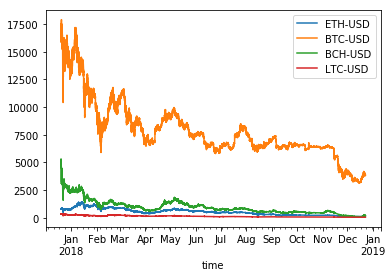

In [9]:
data.plot();

## Test for cointegration

We will test sets o for cointegration and reject hypothesis of absence of cointegration at 90% certanity level.

### Cointegrating Set of Size 2

In [35]:
set_2_results = utils.find_pairs(data, 2, 120)

In [42]:
print("Cointegrating pairs and their weights:")
set_2_results

Cointegrating pairs and their weights:


{('ETH-USD', 'BTC-USD'): array([ 0.00399992, -0.00500023]),
 ('ETH-USD', 'BCH-USD'): array([ 0.00452199, -0.00448732]),
 ('ETH-USD', 'LTC-USD'): array([ 0.00548685, -0.00537173]),
 ('BTC-USD', 'BCH-USD'): array([ 0.00092143, -0.00086576]),
 ('BTC-USD', 'LTC-USD'): array([ 0.00076356, -0.00078147]),
 ('BCH-USD', 'LTC-USD'): array([ 0.00369561, -0.00182794])}

In [43]:
selected_weights = set_2_results[('ETH-USD', 'BTC-USD')]
selected_weights

array([ 0.00399992, -0.00500023])

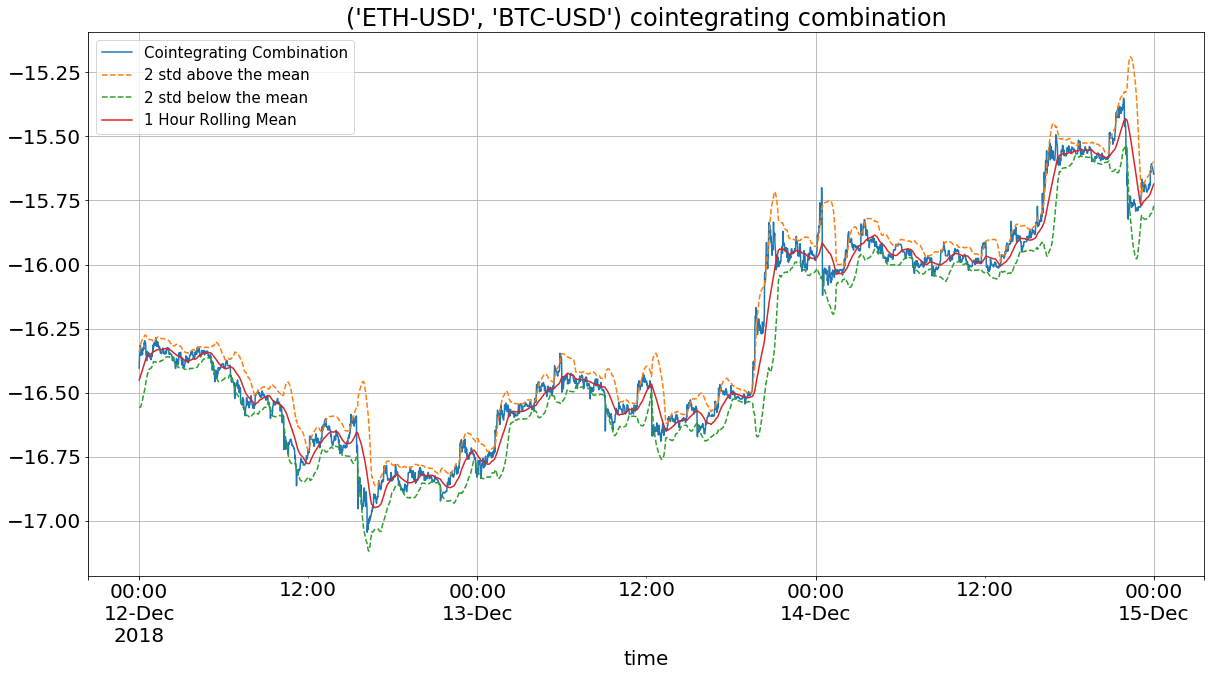

In [40]:
start_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=2)
end_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=5)
utils.draw_cointegration(('ETH-USD', 'BTC-USD'), data, selected_weights, 60, start_date, end_date)

### Cointegrating Set of Size 3

In [44]:
set_3_results = utils.find_pairs(data, 3, 120)

In [45]:
print("Cointegrating pairs and their weights:")
set_3_results

Cointegrating pairs and their weights:


{('ETH-USD',
  'BTC-USD',
  'BCH-USD'): array([-0.00369767, -0.00210385, -0.00503383]),
 ('ETH-USD',
  'BTC-USD',
  'LTC-USD'): array([-0.00430433,  0.00507379, -0.00384691]),
 ('ETH-USD',
  'BCH-USD',
  'LTC-USD'): array([-0.00375966, -0.00467651,  0.00486165]),
 ('BTC-USD',
  'BCH-USD',
  'LTC-USD'): array([-0.00068357,  0.00123929, -0.00032638])}

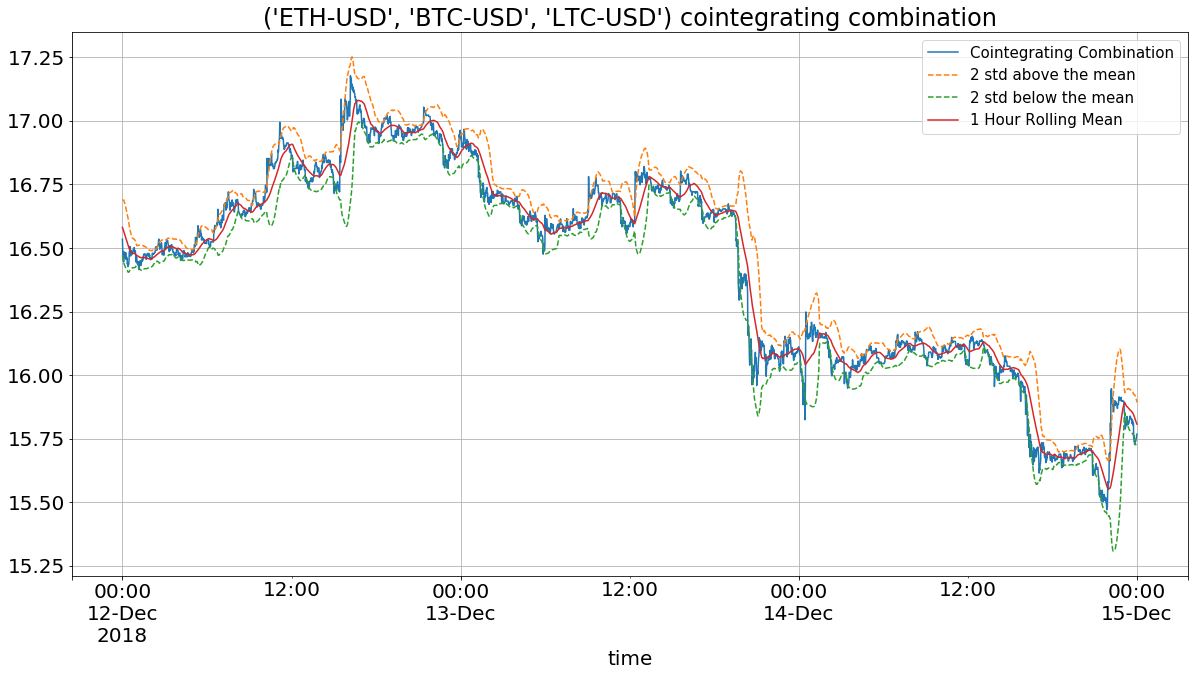

In [46]:
selected_weights = set_3_results[('ETH-USD', 'BTC-USD', 'LTC-USD')]
start_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=2)
end_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=5)
utils.draw_cointegration(('ETH-USD', 'BTC-USD', 'LTC-USD'), data, selected_weights, 60, start_date, end_date)

## Set Size 4

In [16]:
res = utils.find_pairs(data, 4, 120)

In [18]:
res

{('ETH-USD',
  'BTC-USD',
  'BCH-USD',
  'LTC-USD'): array([ 0.00378063,  0.00075437, -0.00571317, -0.00350009])}

In [19]:
selected_weights = res[('ETH-USD', 'BTC-USD', 'BCH-USD','LTC-USD')]
selected_weights

array([ 0.00378063,  0.00075437, -0.00571317, -0.00350009])

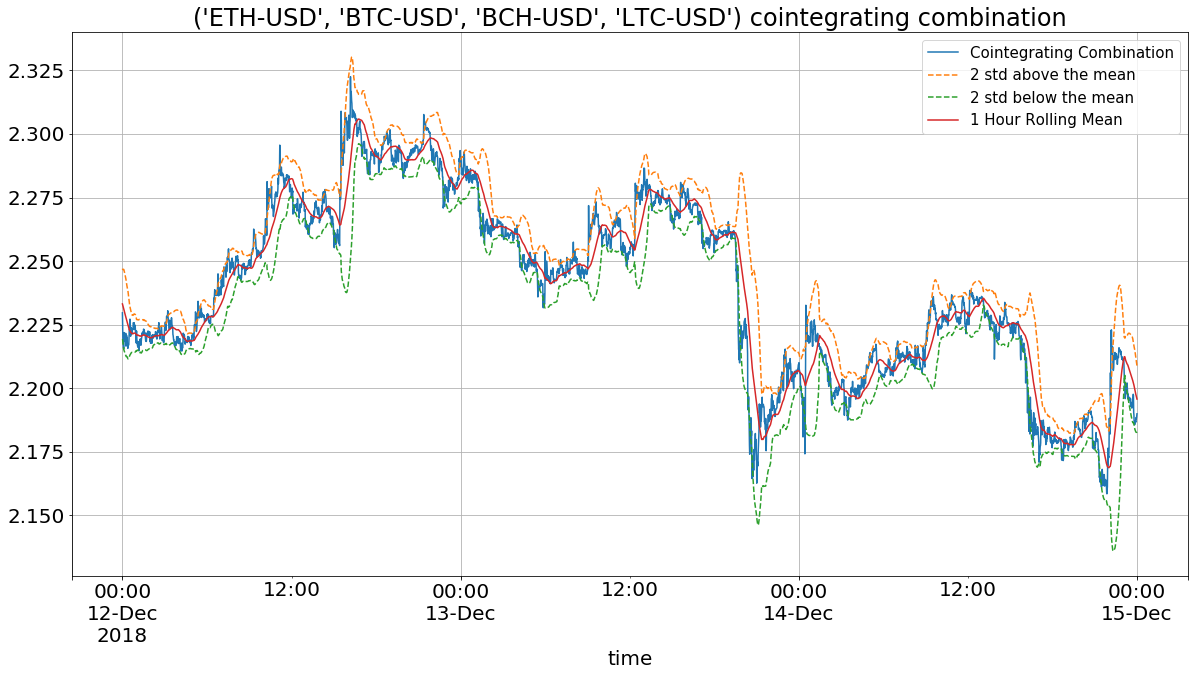

In [32]:
start_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=2)
end_date = COINTEGRATION_RESEARCH_DATE + pd.DateOffset(days=5)
utils.draw_cointegration(('ETH-USD', 'BTC-USD', 'BCH-USD','LTC-USD'), data, selected_weights, 60, 
                         start_date, end_date)

# Conclusion 

As we can see there are a lot of cointegrating sets of pairs, whose linear combination is stationary in a short term time frame (within several hours).